In [108]:
import os
import cv2

from dataset_process import dataset_to_df, search_df

import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.nn as nn

# The cross-entropy loss penalizes the model more when it is more confident in the incorrect class
from torch.nn import CrossEntropyLoss

# Adam is an optimization algorithm that can be used instead of the classical SGD procedure
# to update network weights iterative based in training data.
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
from torchvision.io import read_image

from torchinfo import summary

from einops import rearrange


In [2]:
# np.random.seed(0)
# torch.manual_seed(0)

In [3]:
print(f"torch version: {torch.__version__}")
# torch.cuda.current_device()
# torch.cuda.get_device_name(0)
# torch.cuda.device_count()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Torch is using device:', device)
torch.cuda.get_device_name(device)

NUM_WORKERS = os.cpu_count()
print("CPU Count:", NUM_WORKERS)

torch version: 2.2.1+cu121
Torch is using device: cuda:0
CPU Count: 20


#### Gather all the data from the "CIFAK" dataset to be used later

In [4]:
path = '../../data/CIFAK'
relative_paths = ["/train/REAL", "/train/FAKE", "/test/REAL", "/test/FAKE"]
paths_classes = ["REAL", "FAKE", "REAL", "FAKE"]

In [5]:
df_all, df_train, df_val, df_test, classes_stats = dataset_to_df(
    path, relative_paths, paths_classes, 0.8, 0.19, 0.01)

classes_stats

,REAL,FAKE,Total
Training,48000.0,48000.0,96000.0
Validation,11400.0,11400.0,22800.0
Testing,600.0,600.0,1200.0


In [6]:
df_all.iloc[[0,1,119998,119999]]

,Image_path,Class,Class_Codes
0,../../data/CIFAK//train/REAL/0000(10).jpg,REAL,1
1,../../data/CIFAK//train/REAL/0000(2).jpg,REAL,1
119998,../../data/CIFAK//test/FAKE/999(9).jpg,FAKE,0
119999,../../data/CIFAK//test/FAKE/999.jpg,FAKE,0


#### Determine the number of slices (patches) of the image

In [7]:
Img_horizontal_slices= 4
images_batch = 16

In [8]:
img_shape = read_image(df_all.iloc[0, 0]).size()

slice_width = img_shape[1]//Img_horizontal_slices
total_img_slices = Img_horizontal_slices**2


print("Image Shape: ",img_shape)
print(f"Image will be divided into: {Img_horizontal_slices} x {Img_horizontal_slices} = {total_img_slices} slices")
print("Image Slice Shape: ",(img_shape[0],slice_width,slice_width))
print("")
print(f"Feed ({images_batch}) Images to the Dataloader")
print("")
print(f"Target Shape of the final flattened image: {total_img_slices} x {img_shape[0]*slice_width**2} ")


Image Shape:  torch.Size([3, 32, 32])
Image will be divided into: 4 x 4 = 16 slices
Image Slice Shape:  (3, 8, 8)

Feed (16) Images to the Dataloader

Target Shape of the final flattened image: 16 x 192 


In [9]:
class SliceImage:
    def __init__(self, slice_width):
        self.slice_width = slice_width

    def slice(self, img):
        # img: is a tensor of the shape (Color_Channels x Rows (Hight) x Columns (Width))
        #
        # Make a slice every "slice_width" as we are moving across dimension 1 (as we are moving
        # vertically across rows)
        img = img.unfold(1, self.slice_width, self.slice_width)
        # Make a slice every slice_width as we are moving across dimension 2,
        # Note that previous operation has added new dimension at the beginning
        # refers to no. of vertical slices, hence 2 here still refers to the rows.
        img = img.unfold(2, self.slice_width, self.slice_width)
        return img

    def __call__(self, img):
        img = self.slice(img)
        channels = img.size(0)
        sliced_flattened_img= img.reshape(-1, self.slice_width * self.slice_width * channels)

        return sliced_flattened_img

    plt.show()

In [10]:
# Define the transforms on the input data (x) tensor
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize((32, 32)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    SliceImage(slice_width=slice_width)
])

In [11]:
# Custom Dataset Class
class Images_Dataset(Dataset):
    def __init__(self, annotations_df, transform=None):
        
        self.annotation = annotations_df
        self.transform = transform

    def __getitem__(self, index):
        
        img = read_image(self.annotation.iloc[index, 0])
        labels = torch.tensor(self.annotation.iloc[index, 2], dtype=torch.float64)

        if self.transform:
            img_t = self.transform(img)

        return img, img_t, labels

    def __len__(self):
        # To return the length of the dataset
        return self.annotation.shape[0]

In [12]:
# Define the dataset object and configure the Data Loader

Im_tr_dataset = Images_Dataset(df_train, data_transform)

Im_tr_loader = DataLoader(dataset=Im_tr_dataset,
                          batch_size=images_batch,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)


Im_val_dataset = Images_Dataset(df_val, data_transform)

Im_val_loader = DataLoader(dataset=Im_val_dataset,
                          batch_size=images_batch,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)

#### Plot the original Image and the slices Image

In [13]:
def img_data(Img_train_loader, index):

    date_sample = Img_train_loader.dataset[index]

    img = date_sample[0]
    img_t = date_sample[1]
    label = date_sample[2]

    channels = img.size(0)
    img_size = img.size(1)

    img_slices = img_t.size(0)
    slice_flatsize = img_t.size(1)

    imgs_per_batch = Im_tr_loader.batch_size

    slice_width = int(np.sqrt(slice_flatsize/channels))

    return img, img_t, label, channels, img_size, slice_width, img_slices, slice_flatsize, imgs_per_batch

In [60]:
def img_plot(img, slice_width):
    slice = SliceImage(slice_width)
    sliced_img = slice.slice(img).permute(1, 2, 0, 3, 4)
    print("Sliced Image Shape: ",sliced_img.shape)

    fig = plt.figure(layout="constrained", figsize=(8, 4))
    subfigs = fig.subfigures(3, 1, height_ratios=[1., 1.5,1.],hspace=0.05,squeeze='True')

    axs0 = subfigs[0].subplots(1, 1)
    axs0.imshow(img.permute(1, 2, 0))
    axs0.axis('off')
    # subfigs[0].suptitle('Input Image', fontsize=10)

    grid1 = ImageGrid(subfigs[1], 111, nrows_ncols=(
        sliced_img.size(0), sliced_img.size(1)), axes_pad=0.03)

    for i, ax in enumerate(grid1):
        i_b4 = str(np.base_repr(i, sliced_img.size(0))).zfill(2)
        row = int(i_b4[0])
        column = int(i_b4[1])
        patch = sliced_img[row][column].permute(1, 2, 0).numpy()
        ax.imshow(patch)
        ax.axis('off')
    # subfigs[1].suptitle('Slices', fontsize=10)
    
    grid2 = ImageGrid(subfigs[2], 111, nrows_ncols=
    (1,sliced_img.size(0)*sliced_img.size(1)), axes_pad=0.03)

    for i, ax in enumerate(grid2):
        i_b4 = str(np.base_repr(i, sliced_img.size(0))).zfill(2)
        row = int(i_b4[0])
        column = int(i_b4[1])
        patch = sliced_img[row][column].permute(1, 2, 0).numpy()
        ax.imshow(patch)
        ax.axis('off')
    # subfigs[2].suptitle('Position', fontsize=10)

Input Image Shape: torch.Size([3, 32, 32])
Sliced Image Shape:  torch.Size([4, 4, 3, 8, 8])
Flattened Image Shape: torch.Size([16, 192])


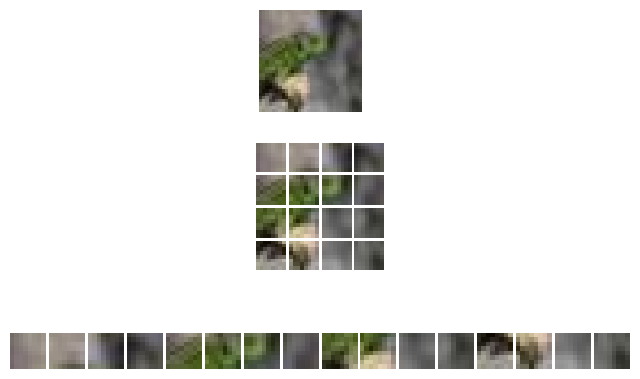

In [62]:
sample_img, sample_img_trans, sample_img_label, ch, img_size, slice_width, slices, slice_flatsize, batch_size = img_data(
    Im_tr_loader, 2)
print(f"Input Image Shape: {sample_img.size()}")
img_plot(sample_img, slice_width)
print(f"Flattened Image Shape: {sample_img_trans.size()}")


slice_embed = slice_flatsize*4

torch.Size([4, 4, 3, 8, 8])


torch.Size([16, 192])

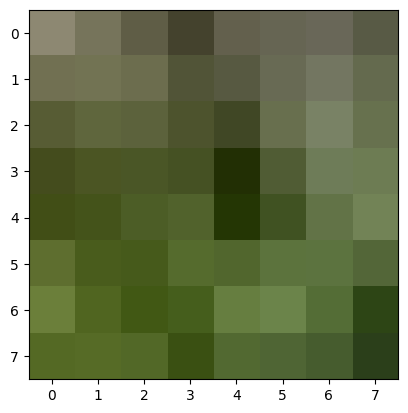

In [106]:
from einops import rearrange, reduce, repeat
bbb = rearrange(sample_img, 'c (h1 h) (w1 w) -> h1 w1 c h w', h1=4, w1=4)
print(bbb.shape)
plt.imshow(rearrange(bbb[1][1],'c h w -> h w c'))
ccc=rearrange(bbb,'h1 w1 c h w -> (h1 w1) (c h w)')
# bbb[0][0].shape
ccc.shape


torch.Size([4, 4, 3, 8, 8])


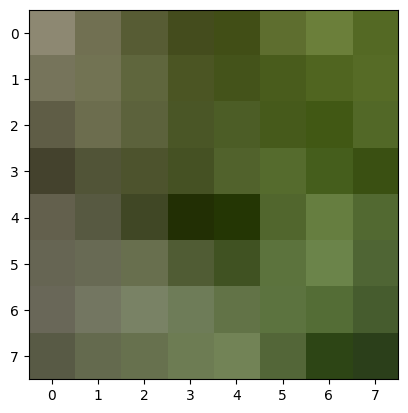

In [107]:
plt.imshow(rearrange(bbb.transpose(-1, -2)[1][1], 'c h w -> h w c'))
# transposes the last dimension (-1) with the dimension just before it (-2)
print(bbb.transpose(-1, -2).shape)

In [ ]:
mat_a=torch.tensor(
    
)

In [118]:
aaaa=torch.randn(2,4,4)
bbbb,cccc= aaaa
print(aaaa)
print(bbbb)
print(cccc)

tensor([[[ 0.6830,  0.9764, -0.6795, -0.3283],
         [ 0.1400,  0.3466, -1.7832, -0.9688],
         [ 1.5097,  0.5240,  0.7832,  0.3844],
         [ 1.9285,  0.5260, -1.7167, -0.1973]],

        [[ 0.6513,  0.6141, -0.9287, -0.6731],
         [-1.8737, -1.2920, -1.2000,  0.5065],
         [-0.2017,  0.1263,  0.0503, -0.5222],
         [-1.2398,  0.2507, -0.7054, -0.0892]]])
tensor([[ 0.6830,  0.9764, -0.6795, -0.3283],
        [ 0.1400,  0.3466, -1.7832, -0.9688],
        [ 1.5097,  0.5240,  0.7832,  0.3844],
        [ 1.9285,  0.5260, -1.7167, -0.1973]])
tensor([[ 0.6513,  0.6141, -0.9287, -0.6731],
        [-1.8737, -1.2920, -1.2000,  0.5065],
        [-0.2017,  0.1263,  0.0503, -0.5222],
        [-1.2398,  0.2507, -0.7054, -0.0892]])


In [63]:
_, sample_img_batch,_ = next(iter(Im_tr_loader))

print(f"Batch of Images Shape: {sample_img_batch.size()}")

Batch of Images Shape: torch.Size([16, 16, 192])


### Build the VIT Model : Embedding &rarr; Transformer Encoder &rarr; MLP_Head

In [65]:
class ImageEmbedding(nn.Module):

    def __init__(self, slice_input_size, slice_embed_size, img_slices, dropout_ratio=0.2):
        super().__init__()

        self.img_to_embed = nn.Linear(slice_input_size, slice_embed_size)
        self.cls_to_embed = nn.Parameter(torch.rand(1,1, slice_embed_size),requires_grad=True)
        self.pos_to_embed = nn.Parameter(torch.rand(img_slices + 1, slice_embed_size),requires_grad=True)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, flattened_imgs):
        # the input is a batch of images each has been sliced to patches and each slice
        # has been flattened. i.e. the shape of the input is:
        # [no. of images ,no. of slices per image, size of the flattened image slice]
        #
        img_embedding = self.img_to_embed(flattened_imgs)

        # create the same cls embedding for all the images in the batch
        #note that img_embedding.size(0) is the number of images in the batch
        cls_embedding = self.cls_to_embed.repeat(img_embedding.size(0), 1, 1)
        # Append the cls embedding to the beginning of the image slices
        img_embedding = torch.concat([cls_embedding, img_embedding], dim=1)

        position_embedding = self.pos_to_embed.repeat(img_embedding.size(0), 1, 1)
        img_and_pos_embedding = img_embedding + position_embedding
        embedding = self.dropout(img_and_pos_embedding)
        return embedding

In [70]:
embedding_layer = ImageEmbedding(slice_input_size=slice_flatsize,
                                 slice_embed_size=slice_embed,
                                 img_slices=slices,
                                 dropout_ratio=0.2)

embedding_output = embedding_layer(sample_img_batch)

print("Input Shape:  ", sample_img_batch.size())
print("Output Shape: ", embedding_output.size())
print("Output Gradient Function: ",embedding_output.grad_fn)
# print(sample_img_label)

# summary(model=embedding_layer,
#         input_size=sample_img_batch.size(),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])



Input Shape:   torch.Size([16, 16, 192])
Output Shape:  torch.Size([16, 17, 768])
Output Gradient Function:  <MulBackward0 object at 0x7f754c2e20b0>


<style>
red { color: red }
yellow { color: yellow }
</style>

##### **<yellow> Query: </yellow>** The query is a feature vector that describes what we are looking for in the sequence, i.e. what would we maybe want to pay attention to.

##### **<yellow> Keys: </yellow>** For each input element, we have a key which is again a feature vector. This feature vector roughly describes what the element is “offering”, or when it might be important. The keys should be designed such that we can identify the elements we want to pay attention to based on the query.

##### **<yellow> Values: </yellow>** For each input element, we also have a value vector. This feature vector is the one we want to average over.

##### **<yellow> Score function: </yellow>** To rate which elements we want to pay attention to, we need to specify a score function . The score function takes the query and a key as input, and output the score/attention weight of the query-key pair. It is usually implemented by simple similarity metrics like a dot product, or a small MLP.

##### A word asks the same question to all words in the sequence using the ‘query’ vector. Similarly, it provides the same answer to all words using the ‘key’ vector. 

$$
\text { Attention }(Q, K, V)=\operatorname{Softmax}\left(\frac{Q K^{\top}}{\sqrt{d}}\right) V
$$
​

In [20]:
class MHAPyTorchScaledDotProduct(nn.Module):
    def __init__(self, d_in, d_out, num_heads, block_size, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.block_size = block_size
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_in, d_out)
        self.dropout = dropout

        self.register_buffer(
            "mask", torch.triu(torch.ones(block_size, block_size), diagonal=1)
        )

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.reshape(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv.unbind(0)

        use_dropout = 0. if not self.training else self.dropout

        context_vec = nn.functional.scaled_dot_product_attention(
            queries, keys, values, attn_mask=None, dropout_p=use_dropout, is_causal=True)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(
            batch_size, num_tokens, self.d_out)

        return context_vec

In [21]:
# MHA_layer = MHAPyTorchScaledDotProduct(d_in=embedding_output.size(2),
#                                  d_out=embedding_output.size(2),
#                                  num_heads=12,
#                                  block_size=embedding_output.size(1),
#                                  dropout=0.0
#                                  )

# MHA_output = MHA_layer(embedding_output)

# print("Input Shape:  ", embedding_output.size())
# print("Output Shape: ", MHA_output.size())

# summary(model=MHA_layer,
#         input_size=embedding_output.size(),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

Input Shape:   torch.Size([16, 17, 384])
Output Shape:  torch.Size([16, 17, 384])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MHAPyTorchScaledDotProduct (MHAPyTorchScaledDotProduct)      [16, 17, 384]        [16, 17, 384]        147,840              True
├─Linear (qkv)                                               [16, 17, 384]        [16, 17, 1152]       442,368              True
Total params: 590,208
Trainable params: 590,208
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 7.08
Input size (MB): 0.42
Forward/backward pass size (MB): 2.51
Params size (MB): 1.77
Estimated Total Size (MB): 4.69

In [22]:
class Encoder(nn.Module):

    def __init__(self, size, context_len, num_heads, dropout=0.1):
        super().__init__()

        self.norm_attention = nn.LayerNorm(size)

        # self.attention = nn.MultiheadAttention(
        #     embed_dim=size,
        #     num_heads=num_heads,
        #     dropout=0.0,
        #     bias=False,
        #     add_bias_kv=False,
        #     batch_first=True)

        self.attention = MHAPyTorchScaledDotProduct(
            d_in=size,
            d_out=size,
            block_size=context_len,
            dropout=0.0,
            num_heads=num_heads,
            qkv_bias=False
        )

        self.norm_feed_forward = nn.LayerNorm(size)
        self.feed_forward = nn.Sequential(
            nn.Linear(size, 4 * size),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(4 * size, size),
            nn.Dropout(dropout))

    def forward(self, input_tensor):
        attn_input = self.norm_attention(input_tensor)

        attn_output = self.attention(attn_input)

        attn_plus_norm = input_tensor + attn_output

        mlp_input = self.norm_feed_forward(attn_plus_norm)
        output = attn_plus_norm + self.feed_forward(mlp_input)

        return output

In [23]:
# encoder_layer = Encoder(size=slice_flatsize, num_heads=12, dropout=0.1)
# encoder_output = encoder_layer(embedding_output)

# print("Output Shape: ", encoder_output.size())

# summary(model=encoder_layer,
#         input_size=embedding_output.size(),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])


In [24]:
class VIT(nn.Module):
    def __init__(self,
                 slice_input_size,
                 slice_embed_size,
                 img_slices,
                 num_classes,
                 num_heads,
                 num_encoders=1,
                 emb_dropout=0.1,
                 enc_dropout=0.1):
        super().__init__()

        self.embedding = ImageEmbedding(
            slice_input_size=slice_input_size,
            slice_embed_size=slice_embed_size,
            img_slices=img_slices,
            dropout_ratio=emb_dropout)

        self.encoders = nn.Sequential(
            *[Encoder(slice_embed_size, img_slices, num_heads, dropout=enc_dropout) for _ in range(num_encoders)],)

        self.mlp_head = nn.Linear(slice_embed_size, num_classes)
        self.out_class = nn.Sigmoid()
        # self.out_class = nn.LogSoftmax(dim=1)

    def forward(self, flattened_img):
        emb = self.embedding(flattened_img)
        attn = self.encoders(emb)
        # output = torch.round(self.sigmoid(self.mlp_head(attn[:, 0, :])))
        output = self.out_class(self.mlp_head(attn[:, 0]))

        return output

#### Define the Model Hyper-parameters Hereunder:

In [25]:
vit_model = VIT(slice_input_size=slice_flatsize,
                slice_embed_size=slice_embed,
                img_slices=slices,
                num_classes=1,
                num_heads=12,
                num_encoders=2,
                emb_dropout=0.1,
                enc_dropout=0.1)

vit_output = vit_model(sample_img_batch)

print("Input Shape: ", sample_img_batch.size())
print("Output Shape: ", vit_output.size())

summary(model=vit_model,
        input_size=sample_img_batch.size(),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Input Shape:  torch.Size([16, 16, 192])
Output Shape:  torch.Size([16, 1])


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
VIT (VIT)                                               [16, 16, 192]        [16, 1]              --                   True
├─ImageEmbedding (embedding)                            [16, 16, 192]        [16, 17, 192]        3,456                True
│    └─Linear (img_to_embed)                            [16, 16, 192]        [16, 16, 192]        37,056               True
│    └─Dropout (dropout)                                [16, 17, 192]        [16, 17, 192]        --                   --
├─Sequential (encoders)                                 [16, 17, 192]        [16, 17, 192]        --                   True
│    └─Encoder (0)                                      [16, 17, 192]        [16, 17, 192]        --                   True
│    │    └─LayerNorm (norm_attention)                  [16, 17, 192]        [16, 17, 192]        384                  True
│    

In [26]:
vit_epochs = 50         # Number of epochs
base_lr = 10e-3         # Base LR
weight_decay = 0.03     # Weight decay for ViT-Base (on ImageNet-21k)

In [27]:
# Betas used for Adam in paper are 0.9 and 0.999, which are the default in PyTorch
vit_optimizer = Adam(vit_model.parameters(), lr=base_lr, weight_decay=weight_decay)
criterion = CrossEntropyLoss() # returns the mean loss for the batch
# scheduler = lr_scheduler.LinearLR(vit_optimizer)

In [28]:
model_state_path="../weights/vit3"

# saved_model = vit_model()
# saved_model.load_state_dict(torch.load(model_state_path))

In [29]:
tr_loss_history = [1000]
tr_accuracy_history = [0]
val_loss_history = [1000]
val_accuracy_history = [0]

vit_model.to(device)

for epoch in range(vit_epochs):

    # Training Loop
    vit_model.train(True)

    accumulated_tr_loss = 0
    accumulated_tr_accuracy = 0
    accumulated_val_loss = 0
    accumulated_val_accuracy = 0

    loop = tqdm(enumerate(Im_tr_loader), total=len(Im_tr_loader))
    for batch, (_, inputs, targets) in loop:

        # Put inputs and labels in device cuda
        tr_images = inputs.to(device)
        sample_img_labels = targets.to(device)

        # Zero gradients for every batch
        vit_optimizer.zero_grad()

        # Forward Path
        tr_outputs = vit_model(tr_images).squeeze(1)

        loss = criterion(tr_outputs,sample_img_labels)

        accumulated_tr_loss += loss.item()
        accumulated_tr_accuracy += (sample_img_labels == tr_outputs).sum().item()/sample_img_labels.size(0)
        
        avg_tr_loss = accumulated_tr_loss / (batch+1)
        avg_tr_accuracy = 100*accumulated_tr_accuracy / (batch+1)

        # Backward path (Gradient)
        loss.backward()

        # Optimizer(Adam) Step
        vit_optimizer.step()

        loop.set_description(f"Epoch [{epoch+1}/{vit_epochs}]")
        loop.set_postfix(loss=avg_tr_loss, acc=avg_tr_accuracy)
    
    tr_loss_history.append(avg_tr_loss)
    tr_accuracy_history.append(avg_tr_accuracy)

    # scheduler.step()


# Validation Loop
    vit_model.eval()

    with torch.no_grad():

        for batch, (_, inputs, targets) in enumerate(Im_val_loader):

            # Put inputs and labels in device cuda
            val_images = inputs.to(device)
            val_labels = targets.to(device)

            val_outputs = vit_model(val_images).squeeze(1)

            loss = criterion(val_outputs,val_labels)

            accumulated_val_loss += loss.item()
            accumulated_val_accuracy += (val_labels == val_outputs).sum().item()/val_labels.size(0)

            avg_val_loss = accumulated_val_loss / (batch+1)
            avg_val_accuracy = 100*accumulated_val_accuracy / (batch+1)

        
        best_val_loss=min(val_loss_history)
        if avg_val_loss < best_val_loss:
            torch.save(vit_model.state_dict(), model_state_path+f'_epoch_{epoch}')

        val_loss_history.append(avg_val_loss)
        val_accuracy_history.append(avg_val_accuracy)

        print(f'Validation loss: {avg_val_loss:.2f} | Validation accuracy: {avg_val_accuracy:.2f}')
        print("------------------------------------------------------------------------------------")

Epoch [1/50]: 100%|██████████| 6000/6000 [00:40<00:00, 147.25it/s, acc=0.14, loss=nan] 


Validation loss: nan | Validation accuracy: 0.00
------------------------------------------------------------------------------------


Epoch [2/50]: 100%|██████████| 6000/6000 [00:41<00:00, 144.73it/s, acc=0, loss=nan]


Validation loss: nan | Validation accuracy: 0.00
------------------------------------------------------------------------------------


Epoch [3/50]:  95%|█████████▍| 5675/6000 [00:39<00:02, 144.69it/s, acc=0, loss=nan]


KeyboardInterrupt: 

In [ ]:
for param_tensor in vit_model.state_dict():
    print(param_tensor, "\t", vit_model.state_dict()[param_tensor].size())

In [ ]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(range(len(tr_loss_history )), tr_loss_history , label='Train Loss')
axs[1].plot(range(len(tr_accuracy_history)), tr_accuracy_history, label='Validation Loss')
axs[0].plot(range(len(val_loss_history)), val_loss_history, label='Train Accuracy')
axs[1].plot(range(len(val_accuracy_history)), val_accuracy_history, label='Validation Accuracy')
plt.show()